In [1]:
import accelerate
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration, set_seed
from diffusers import UNet2DModel
from diffusers.training_utils import EMAModel
from packaging import version
import torch
import torch.nn.functional as F
import numpy as np
from dataloader.dataset_class import inverse_normalize_transform, pdedata2dataloader
import os
import copy
from pathlib import Path
from tqdm.auto import tqdm
from utils.inverse_utils import create_scatter_mask, edm_sampler, ensemble_sample
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from einops import rearrange, repeat


from pipelines.pipeline_inv_prob import InverseProblem2DPipeline
#from noise_schedulers.noise_scheduler_inverseproblem import EDMDPMSolverMultistepScheduler_inv
#from noise_schedulers.add_noise_scheduler import KarrasEDMSigmaScheduler
from utils.general_utils import instantiate_from_config, plot_channel, plot_ensemble, plot_steps, plot_one_sample, calculate_covariance
from utils.vt_utils import vt_obs
from noise_schedulers.noise_sampler import Karras_sigmas_lognormal
from losses.metric import metric_func_2D, get_metrics_2D

/home/ylzhuang/anaconda3/envs/dm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:2'

# Instantiate models from config

Checkpoint loading handled by the accelerator

In [3]:
#config = OmegaConf.load('configs/darcy_config.yaml')
config = OmegaConf.load('configs/diffusion_reaction_config.yaml')
#config = OmegaConf.load('configs/shallow_water_config.yaml')

unet_config = OmegaConf.to_container(config.pop("unet", OmegaConf.create()), resolve=True)
noise_scheduler_config = config.pop("noise_scheduler", OmegaConf.create())
accelerator_config = config.pop("accelerator", OmegaConf.create())
loss_fn_config = config.pop("loss_fn", OmegaConf.create())
optimizer_config = config.pop("optimizer", OmegaConf.create())
lr_scheduler_config = config.pop("lr_scheduler", OmegaConf.create())    
dataloader_config = config.pop("dataloader", OmegaConf.create())
ema_config = config.pop("ema", OmegaConf.create())
general_config = config.pop("general", OmegaConf.create())

set_seed(general_config.seed)


unet = UNet2DModel.from_config(config=unet_config)

logging_dir = Path(general_config.output_dir, general_config.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=general_config.output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    project_config=accelerator_project_config,
    **accelerator_config
)

# Create EMA for the model.
if ema_config.use_ema:
    ema_model = EMAModel(
        unet.parameters(),
        decay=ema_config.ema_max_decay,
        use_ema_warmup=True,
        inv_gamma=ema_config.ema_inv_gamma,
        power=ema_config.ema_power,
        model_cls=UNet2DModel,
        model_config=unet.config,
        foreach = ema_config.foreach,
    )

# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            if ema_config.use_ema:
                ema_model.save_pretrained(os.path.join(output_dir, "unet_ema"))

            for i, model in enumerate(models):
                model.save_pretrained(os.path.join(output_dir, "unet"))

                # make sure to pop weight so that corresponding model is not saved again
                weights.pop()

    def load_model_hook(models, input_dir):
        if ema_config.use_ema:
            load_model = EMAModel.from_pretrained(
                os.path.join(input_dir, "unet_ema"), UNet2DModel#, foreach=ema_config.foreach
            )
            ema_model.load_state_dict(load_model.state_dict())
            if ema_config.offload_ema:
                ema_model.pin_memory()
            else:
                ema_model.to(accelerator.device) 
            del load_model

        for _ in range(len(models)):
            # pop models so that they are not loaded again
            model = models.pop()

            # load diffusers style into model
            load_model = UNet2DModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

noise_scheduler = instantiate_from_config(noise_scheduler_config)
#inv_noise_scheduler_class = get_inv_noise_scheduler(noise_scheduler_config["scheduler_name"]) 
#noise_scheduler = inv_noise_scheduler_class(**noise_scheduler_config["scheduler_params"])

noise_sampler = Karras_sigmas_lognormal(noise_scheduler.sigmas, P_mean=2.3, P_std=2.0)

loss_fn = instantiate_from_config(loss_fn_config)

generator = torch.Generator(device=device).manual_seed(general_config.seed)
train_dataset, val_dataset, test_dataset = pdedata2dataloader(**dataloader_config, generator=generator, data_name=general_config.data_name,
                                                              return_dataset=True)

#'''
unet = accelerator.prepare(unet)

if ema_config.use_ema:
    ema_model.to(device)
#'''

Splitting dataset by length.


# Break down the config

## Unet

```yaml
unet:
  _class_name: UNet2DModel
  _diffusers_version: 0.28.2
  act_fn: silu
  add_attention: true
  attention_head_dim: 8
  attn_norm_num_groups: null
  block_out_channels:
    - 128
    - 256
    - 256
    - 256
  center_input_sample: false
  class_embed_type: null
  down_block_types:
    - DownBlock2D
    - AttnDownBlock2D
    - AttnDownBlock2D
    - AttnDownBlock2D
  downsample_padding: 1
  downsample_type: conv
  dropout: 0.0
  flip_sin_to_cos: true
  freq_shift: 0
  in_channels: 3
  layers_per_block: 2
  mid_block_scale_factor: 1
  norm_eps: 1e-05
  norm_num_groups: 32
  num_class_embeds: null
  num_train_timesteps: null
  out_channels: 2
  resnet_time_scale_shift: scale_shift
  sample_size: 128
  time_embedding_type: positional
  up_block_types:
    - UpBlock2D
    - AttnUpBlock2D
    - AttnUpBlock2D
    - AttnUpBlock2D
  upsample_type: conv
```

By default theses blocks all have residual connections, the 'scale_shift' parameter denotes the Feature-wise Linear Modulation (FiLM) operation.
$$FiLM(x) = \gamma(z) \cdot x + \beta(z)$$
Here, $z$ is the conditioning input. Latnet size: 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8

## Noise scheduler
  
```yaml
noise_scheduler:
  target: diffusers.EDMDPMSolverMultistepScheduler
  params:
    num_train_timesteps: 1000
```

We used the 'EDM'-type scheduler, which is a bit different from the rest of the schedulers. The EDM-type scheduler has:
```python
def scale_model_input(self, sample: torch.Tensor, timestep: Union[float, torch.Tensor]) -> torch.Tensor:
    """
    Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
    current timestep. Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the Euler algorithm.
    """
    if self.step_index is None:
        self._init_step_index(timestep)

    sigma = self.sigmas[self.step_index]
    sample = self.precondition_inputs(sample, sigma)

    self.is_scale_input_called = True
    return sample

# Other schedulers
def scale_model_input(self, sample: torch.Tensor, timestep: Union[float, torch.Tensor]) -> torch.Tensor:
  
  return sample
```
The `num_train_timesteps` parameter represents how fine your noise schedule is. By default, diffusers use linear schedules with uniform distribution.

# Loss function

```yaml
loss_fn:
  target: losses.loss.EDMLoss
  params:
    sigma_data: 0.5
```
The EDM is also referred as the F-prediction, the loss function is a weighted x-prediction.

# Optimizer

```yaml
optimizer:
  betas:
    - 0.9
    - 0.999
  eps: 1e-08
  lr: 1e-4
  weight_decay: 1e-2
```
AdamW

# LR Scheduler

```yaml
lr_scheduler:
  name: cosine
  num_warmup_steps: 500
  num_cycles: 0.5
  power: 1.0
```

Cosine annealing with warmup

## Dataloader

```yaml
dataloader:
  data_dir: <path_to_data> # can be npy/hdf5
  batch_size: 32
  num_workers: 8
  split_ratios: 
    - 0.8
    - 0.2
    - 0.0
  transform: normalize
  transform_args:
    mean: [-0.0311127,  -0.0199022]
    std: [0.1438150, 0.1117546] 
    target_std: 0.5
```

The EDM hyperparams are designed for data with std 0.5, we compute the mean and std from train dataset, and perform the inverse transform before evaluating metrics.

```py
elif data_name == 'diffusion_reaction':
    keys = ['data']
    full_dataset = read_hdf5_to_numpy(data_dir, keys[0])
    full_dataset = rearrange(full_dataset, 'n t x y c -> (n t) c x y')
    return npy2dataloader(full_dataset, batch_size, num_workers, split_ratios=split_ratios, transform=transform, transform_args=transform_args,
                          rearrange_args=rearrange_args, random_dataset=False, generator=generator, return_dataset=return_dataset)
```

## Accelerator

```yaml
accelerator:
  mixed_precision: fp16
  gradient_accumulation_steps: 1
  log_with: tensorboard
```

Distributed training handled by Hugging face 🤗 [Accelerate](https://github.com/huggingface/accelerate)

## EMA

```yaml
ema:
  use_ema: True
  offload_ema: False
  ema_max_decay: 0.9999
  ema_inv_gamma: 1.0
  ema_power: 0.75
  foreach: True
```

Exponential Moving Averate (EMA) weight:

For some running average weight, $\hat{\theta}$, we update the weight as:
$$ \hat{\theta} = \beta \hat{\theta}(t-1) + (1-\beta)\theta(t)$$
It helps to avoid overfitting to the last batch, i.e., we save two sets of model weights.

## General

```yaml
general:
  seed: 42
  num_epochs: null
  num_training_steps: 150000
  known_channels: [0,1]
  same_mask: True
  scale_lr: False
  output_dir: ./log/diffusion_reaction_ema
  logging_dir: diff_react
  tracker_project_name: diffreact_tracker
  save_image_epochs: 1
  save_model_epochs: 10
  checkpointing_steps: 1000
  eval_batch_size: 8
  do_edm_style_training: True
  channel_names: ["u", "v"]
  data_name: diffusion_reaction
```

Specify either `num_training_steps` or `num_epochs`

# Training of the model

```py
for step, batch in enumerate(train_dataloader):
    with accelerator.accumulate(unet):
        clean_images = batch
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape, device=clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        # diffusers/examples/dreambooth/train_dreambooth_lora_sdxl.py
        if not general_config.do_edm_style_training:
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            )
            timesteps = timesteps.long()
        else:
            #indices = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,))
            indices = noise_sampler(bs, device='cpu')
            timesteps = noise_scheduler.timesteps[indices].to(device=clean_images.device)

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        mask = create_scatter_mask(clean_images, channels=general_config.known_channels, ratio=torch.rand(1, device=clean_images.device))
        noise = noise * (1 - mask)
        if general_config.same_mask:
            # Only use one of the known channels in this case
            concat_mask = mask[:, [general_config.known_channels[0]]]
        else:
            concat_mask = mask[:, general_config.known_channels]
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noisy_images = torch.concatenate((noisy_images, concat_mask), dim=1)

        if general_config.do_edm_style_training:
            sigmas = get_sigmas(noise_scheduler, timesteps, len(noisy_images.shape), noisy_images.dtype, device=accelerator.device)
            x_in = noise_scheduler.precondition_inputs(noisy_images, sigmas) #scale_model_input designed for step
        model_output = unet(x_in, timesteps, return_dict=False)[0]
        weighting = None
        if general_config.do_edm_style_training:
            model_output = noise_scheduler.precondition_outputs(noisy_images[:, :unet_config['out_channels']], model_output, sigmas) # the last (or more) channel is the mask
            loss = loss_fn(model_output, clean_images, sigmas)

        train_loss += loss.item() / accelerator.gradient_accumulation_steps

        accelerator.backward(loss)
        if accelerator.sync_gradients:
            accelerator.clip_grad_norm_(unet.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
```

With Accelerate, the training script is 'pytorch-like', from the official [guide](https://huggingface.co/docs/accelerate/en/quicktour):
```py
+ from accelerate import Accelerator
+ accelerator = Accelerator()

+ device = accelerator.device
+ model, optimizer, training_dataloader, scheduler = accelerator.prepare(
+     model, optimizer, training_dataloader, scheduler
+ )

  for batch in training_dataloader:
      optimizer.zero_grad()
      inputs, targets = batch
-     inputs = inputs.to(device)
-     targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_function(outputs, targets)
+     accelerator.backward(loss)
      optimizer.step()
      scheduler.step()
```

## train the model:

First stepup the accelerate config (or link to the dir of the config file)
```shell
accelerate config
```
Execute the train.py:

```shell
accelerate launch --mixed_precision=fp16 --num_processes=2 train.py --config configs/diffusion
_reaction_config.yaml --checkpoints_total_limit=10
```

In [4]:
# select the snapshot indices for validation dataset
snapshot_idx_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
batch = val_dataset[snapshot_idx_list]
#batch = train_dataset[snapshot_idx_list]
batch = batch.to(device)
print(batch.shape)

torch.Size([10, 2, 128, 128])


validation dataset is not seen by the model during training. (did not save the best weights)

In [5]:
# load the checkpoint
dirs = os.listdir(general_config.output_dir)
dirs = [d for d in dirs if d.startswith("checkpoint")]
dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
path = dirs[-1] if len(dirs) > 0 else None
accelerator.load_state(os.path.join(general_config.output_dir, path))
unet = unet.to(device)
unet.eval()
#unet = torch.compile(unet, mode="reduce-overhead", fullgraph=True)
print('loaded checkpoint: ', path)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 150000, 'power': 0.75, 'update_after_step': 0, 'use_ema_warmup': True} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


loaded checkpoint:  checkpoint-150000


In [6]:
# Override the weight of unet by the EMA model.
#'''
if ema_config.use_ema:
    ema_model.store(unet.parameters())
    ema_model.copy_to(unet.parameters())
#'''

In [7]:
pipeline = InverseProblem2DPipeline(unet, scheduler=copy.deepcopy(noise_scheduler))

In [8]:
scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)

In [9]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred_traj = pipeline.return_trajectory(batch_size=batch.shape[0], mask=scatter_mask, known_channels=general_config.known_channels, known_latents=batch,
                    num_inference_steps=20, return_dict=False, same_mask=general_config.same_mask, generator=generator)[0]
    pred = pred_traj[-1]

20it [00:10,  1.99it/s]


In [10]:
plot_steps(pred_traj, 2, 0, 4, mask=scatter_mask)

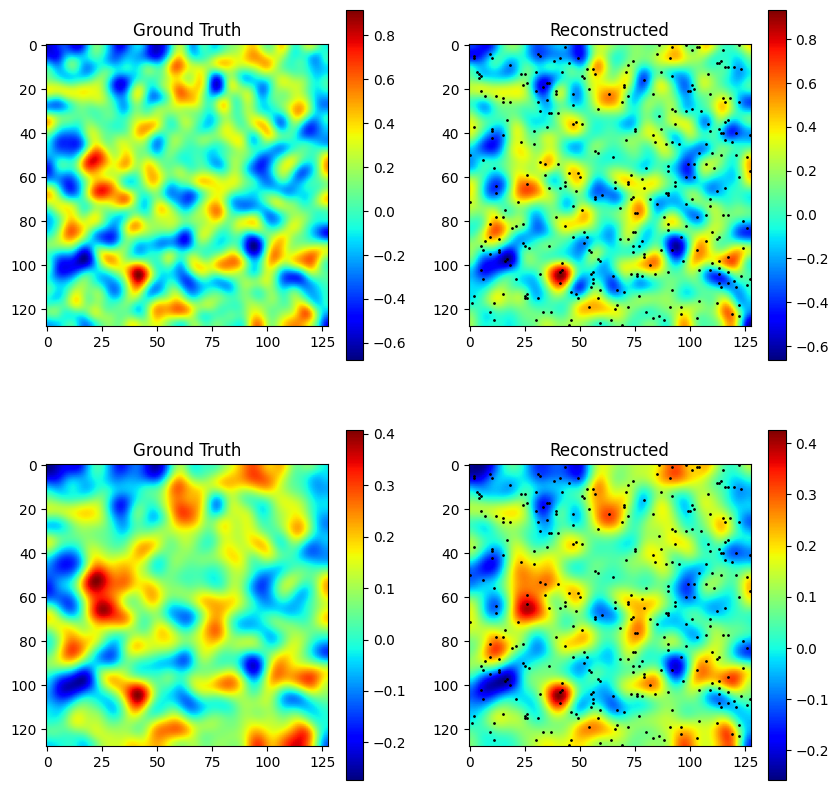

RMSE:  tensor(0.0194, device='cuda:2') NRMSE:  tensor(0.2966, device='cuda:2') CSV:  tensor(32.5653, device='cuda:2')


In [11]:
idx = 2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Ground Truth")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Reconstructed")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Ground Truth")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Reconstructed")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
# if mask is provided, err is computed on unknown values
rmse, nrmse, csv = metric_func_2D(orig_pred, orig_batch, mask=scatter_mask)
print('RMSE: ', rmse, 'NRMSE: ', nrmse, 'CSV: ', csv)

# Breakdown of a single denoising step

In [12]:
from noise_schedulers.noise_sampler import Karras_sigmas_lognormal
from diffusers import EDMDPMSolverMultistepScheduler
from utils.pipeline_utils import get_sigmas

noise_scheduler = EDMDPMSolverMultistepScheduler()
with torch.no_grad():
    clean_images = batch.clone()
    noise = torch.randn(clean_images.shape, device=device)
    bs = clean_images.shape[0]
    indices = torch.randint(0, 1000, (bs,))
    indices[idx] = 100
    print('indice: ', indices[idx])
    timesteps = noise_scheduler.timesteps[indices].to(device=clean_images.device)
    sigmas = get_sigmas(noise_scheduler, timesteps, len(clean_images.shape), clean_images.dtype, device=device)
    print('sigmas: ', sigmas[idx])
    #mask_ratio = torch.rand(1, device=clean_images.device)
    mask_ratio = 0.02
    print('mask_ratio: ', mask_ratio)
    mask = create_scatter_mask(clean_images, channels=general_config.known_channels, ratio=mask_ratio)
    #noise = noise * (1 - mask)
    concat_mask = mask[:, [0]]
    #noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    noisy_images = torch.randn_like(clean_images)*sigmas
    noisy_images = noisy_images * (1 - mask) + clean_images * mask
    noisy_images = torch.concatenate((noisy_images, concat_mask), dim=1)

    x_in = noise_scheduler.precondition_inputs(noisy_images, sigmas) #scale_model_input designed for step
    #x_in = torch.concatenate((x, concat_mask), dim=1)
    tmp_model_output = unet(x_in, timesteps, return_dict=False)[0]
    model_output = noise_scheduler.precondition_outputs(noisy_images[:, :unet_config['out_channels']], tmp_model_output, sigmas)

indice:  tensor(100)
sigmas:  tensor([[[45.2869]]], device='cuda:2')
mask_ratio:  0.02


tensor(0.0615, device='cuda:2')


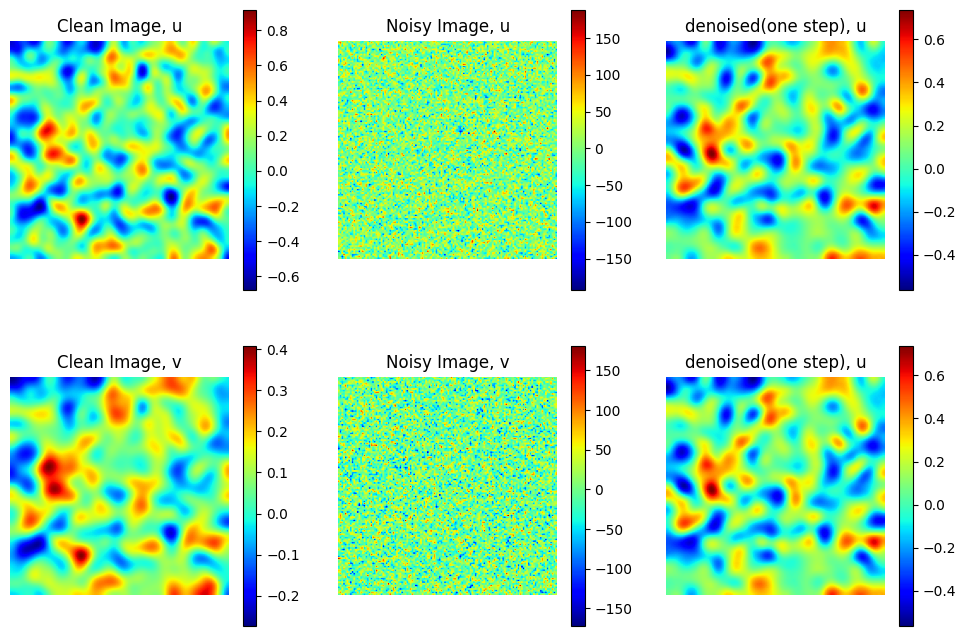

In [13]:
print(sigmas.flatten()[0])
fig, axs = plt.subplots(2, 3, figsize=(12,8))

im = axs[0, 0].imshow(clean_images[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title('Clean Image, u')
axs[0, 0].axis('off')
fig.colorbar(im, ax=axs[0, 0])  # Add colorbar

im = axs[0, 1].imshow(noisy_images[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].set_title('Noisy Image, u')
axs[0, 1].axis('off')
fig.colorbar(im, ax=axs[0, 1])  # Add colorbar

im = axs[0, 2].imshow(model_output[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 2].set_title('denoised(one step), u')
axs[0, 2].axis('off')
fig.colorbar(im, ax=axs[0, 2])  # Add colorbar

im = axs[1, 0].imshow(clean_images[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title('Clean Image, v')
axs[1, 0].axis('off')
fig.colorbar(im, ax=axs[1, 0])  # Add colorbar

im = axs[1, 1].imshow(noisy_images[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title('Noisy Image, v')
axs[1, 1].axis('off')
fig.colorbar(im, ax=axs[1, 1])  # Add colorbar

im = axs[1, 2].imshow(model_output[idx, 0].cpu().numpy(), cmap='jet')
axs[1, 2].set_title('denoised(one step), u')
axs[1, 2].axis('off')
fig.colorbar(im, ax=axs[1, 2])  # Add colorbar

plt.show()

In [14]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred = edm_sampler(unet, noise_scheduler, batch_size=batch.shape[0], class_labels=None, known_latents=batch*scatter_mask, mask=scatter_mask,
                           same_mask=general_config.same_mask, known_channels=general_config.known_channels, num_inference_steps=20,
                           device = device, generator=generator)

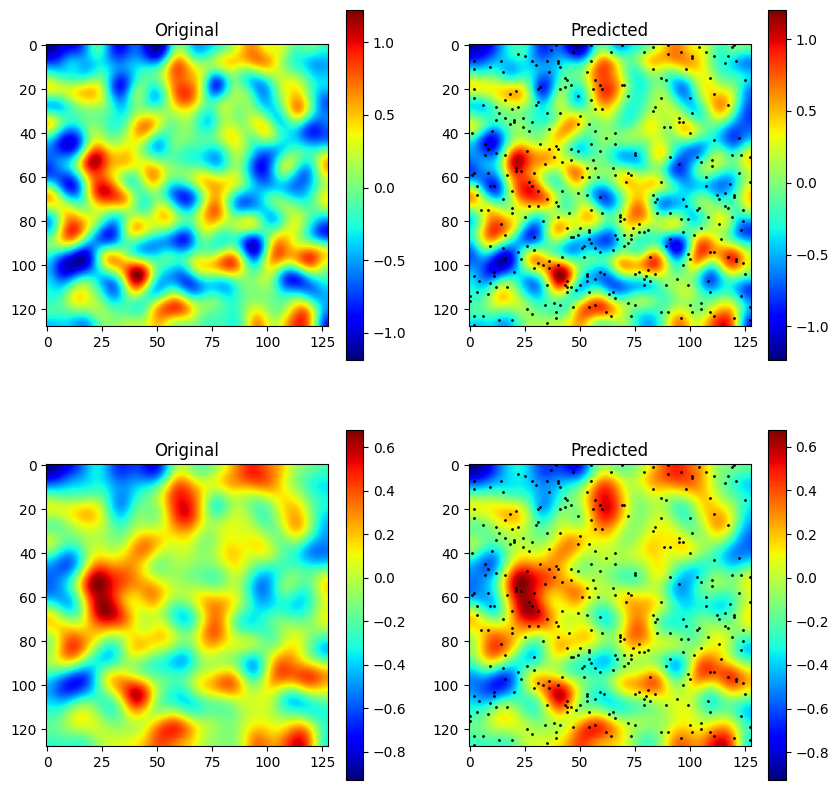

RMSE:  tensor(0.0220, device='cuda:2', dtype=torch.float64) NRMSE:  tensor(0.3467, device='cuda:2', dtype=torch.float64) CSV:  tensor(33.5957, device='cuda:2', dtype=torch.float64)


In [15]:
idx = 6
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Original")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Predicted")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Original")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Predicted")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
# if mask is provided, err is computed on unknown values
rmse, nrmse, csv = metric_func_2D(orig_pred, orig_batch, mask=scatter_mask)
print('RMSE: ', rmse, 'NRMSE: ', nrmse, 'CSV: ', csv)

# Now swich to structure sampling (vt style)

Total number of observation points:  <built-in method size of Tensor object at 0x7f7d9a51b350>


/home/ylzhuang/myproj/diffuserPDE/utils/vt_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interpolated_fields[idx] = torch.tensor(interpolated_values,


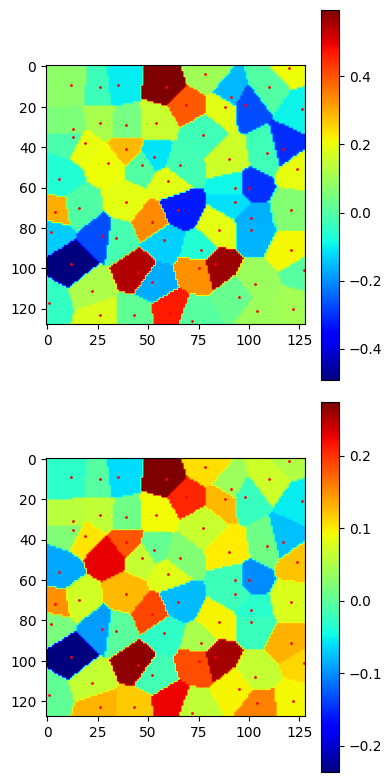

In [16]:
tmp_dim = unet.config.sample_size
spacing = 16
vt = vt_obs(x_dim=tmp_dim, y_dim=tmp_dim, x_spacing=spacing, y_spacing=spacing, #device=device)
            known_channels=general_config.known_channels, device=device)
print('Total number of observation points: ', vt.x_start_grid.size)
#vt._plot_vt(batch[2], mask=scatter_mask[2])
vt._plot_vt(batch[2])

In [17]:
# get x, y coordinates
scatter_mask = torch.empty(batch.shape, device=device)
for i in range(batch.shape[0]):
    x_idx, y_idx = vt.structure_obs(generator=generator)
    tmp_mask = create_scatter_mask(batch, channels=general_config.known_channels, x_idx=x_idx, y_idx=y_idx)
    scatter_mask[i] = tmp_mask[0]

In [18]:
with torch.no_grad():
    #scatter_mask = create_scatter_mask(batch, channels=general_config.known_channels, ratio=0.02)
    pred = edm_sampler(unet, noise_scheduler, batch_size=batch.shape[0], class_labels=None, known_latents=batch*scatter_mask, mask=scatter_mask,
                           same_mask=general_config.same_mask, known_channels=general_config.known_channels, num_inference_steps=20,
                           device = device, generator=generator)

In [19]:
idx = 5
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im0 = axs[0, 0].imshow(batch[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 0].set_title("Ground Truth")
fig.colorbar(im0, ax=axs[0, 0])  # Add colorbar for the first plot

im1 = axs[0, 1].imshow(pred[idx, 0].cpu().numpy(), cmap='jet')
axs[0, 1].scatter(np.where(scatter_mask[idx, 0].cpu().numpy())[1], np.where(scatter_mask[idx, 0].cpu().numpy())[0], c='black', s=1)
axs[0, 1].set_title("Reconstructed")
fig.colorbar(im1, ax=axs[0, 1])  # Add colorbar for the second plot

im2 = axs[1, 0].imshow(batch[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 0].set_title("Ground Truth")
fig.colorbar(im2, ax=axs[1, 0])  # Add colorbar for the third plot

im3 = axs[1, 1].imshow(pred[idx, 1].cpu().numpy(), cmap='jet')
axs[1, 1].set_title("Reconstructed")
axs[1, 1].scatter(np.where(scatter_mask[idx, 1].cpu().numpy())[1], np.where(scatter_mask[idx, 1].cpu().numpy())[0], c='black', s=1)
fig.colorbar(im3, ax=axs[1, 1])  # Add colorbar for the fourth plot
plt.show()

# data is normalized, need to transform back to original scale
orig_pred = inverse_normalize_transform(pred, **val_dataset.transform_args)
orig_batch = inverse_normalize_transform(batch, **val_dataset.transform_args)
# if mask is provided, err is computed on unknown values
#metric_func_2D(orig_pred[:,[0]], orig_batch[:,[0]], mask=scatter_mask[:,[0]])
#metric_func_2D(orig_pred, orig_batch, mask=scatter_mask)
rmse, nrmse, csv = metric_func_2D(orig_pred, orig_batch, mask=scatter_mask)
print('RMSE: ', rmse, 'NRMSE: ', nrmse, 'CSV: ', csv)

RMSE:  tensor(0.0686, device='cuda:2', dtype=torch.float64) NRMSE:  tensor(0.9038, device='cuda:2', dtype=torch.float64) CSV:  tensor(75.4359, device='cuda:2', dtype=torch.float64)


In [20]:
sampler_kwargs = {
    "num_inference_steps": 20,
    "known_channels": general_config.known_channels,
}
samples = ensemble_sample(pipeline, sample_size=25, sampler_kwargs=sampler_kwargs, mask=scatter_mask[[idx]], 
                          known_latents=batch[[idx]]*scatter_mask[[idx]],
                          sampler_type="edm", device=device)

In [23]:
plot_ensemble(samples, title='u, v-ensemble', mask=scatter_mask[idx], cb=True, GT=batch[idx].cpu().numpy())

In [20]:
sampler_kwargs = {
    "num_inference_steps": 20,
    "known_channels": general_config.known_channels,
}
mask_kwargs = {
    "channels": general_config.known_channels,
}
err_RMSE, err_nRMSE, err_CSV = get_metrics_2D(val_dataset, pipeline=pipeline,
                                              vt = vt,
                                              vt_model = None,
                                              batch_size = 64,
                                              ensemble_size = 25,
                                              sampler_kwargs = sampler_kwargs,
                                              mask_kwargs = mask_kwargs,
                                              device = device,
                                              mode = 'edm',
                                              inverse_transform = 'normalize',
)

Calculating metrics for edm, ensemble size: 25


100%|██████████| 40/40 [2:19:46<00:00, 209.65s/it]  


In [21]:
print(f'RMSE: {err_RMSE.float():.7f}, nRMSE: {err_nRMSE:.7f}, CSV: {err_CSV:.7f}')

RMSE: 0.0012874, nRMSE: 0.1312285, CSV: 0.5427231


# Start of DA

**Note**: Need to to the inverse of the normalization to get the fields

In [23]:
u_cov = calculate_covariance(samples, channel=0)